In [64]:
###################################################################################
##
## From https://github.com/keras-team/keras/blob/master/examples/cifar10_resnet.py
##
###################################################################################

from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

In [65]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8538861898910734175
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3315204096
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11361429964739130051
physical_device_desc: "device: 0, name: GeForce GTX 970, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


In [96]:
# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 100
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

wide = True
factor = 5
drop = True

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
if wide:
    model_type = 'Wide-ResNet%dv%d-%d' % (depth, version, factor)
else:
    model_type = 'ResNet%dv%d' % (depth, version)

In [97]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [98]:
# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [99]:
def lr_schedule(epoch):

    lr = 1e-3
    if epoch > 80:
        lr *= 0.5e-3
    elif epoch > 60:
        lr *= 1e-3
    elif epoch > 40:
        lr *= 1e-2
    elif epoch > 20:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):

    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10, wide=False, factor=1, drop=False):

    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16*factor
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs, num_filters=num_filters, conv_first=False)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides,
                             conv_first=False)
            if drop:
                y = Dropout(0.2)(y)
                
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None,
                             conv_first=False)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False,
                                 conv_first=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10, wide=False, factor=1, drop=False):

    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [100]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth, wide=wide, factor=factor, drop=drop)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth, wide=wide, factor=factor, drop=drop)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

Learning rate:  0.001
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_161 (BatchN (None, 32, 32, 3)    12          input_12[0][0]                   
__________________________________________________________________________________________________
activation_158 (Activation)     (None, 32, 32, 3)    0           batch_normalization_161[0][0]    
__________________________________________________________________________________________________
conv2d_177 (Conv2D)             (None, 32, 32, 80)   2240        activation_158[0][0]             
______________________________________________________________________

In [101]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [102]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [103]:
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=20,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.1,
        # set range for random zoom
        zoom_range=0.1,
        # set range for random channel shifts
        channel_shift_range=0.1,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=5,
                        callbacks=callbacks)

Using real-time data augmentation.
Epoch 1/100
Learning rate:  0.001
391/391 [==============================] - 122s 299ms/step - loss: 3.1097 - accuracy: 0.2984 - val_loss: 2.5688 - val_accuracy: 0.4199

Epoch 00001: val_accuracy improved from -inf to 0.41990, saving model to /home/vicdoja/repos/ComputerVision-Labs/saved_models/cifar10_Wide-ResNet20v1-5_model.001.h5
Epoch 2/100
Learning rate:  0.001
391/391 [==============================] - 115s 292ms/step - loss: 2.1647 - accuracy: 0.4970 - val_loss: 2.0077 - val_accuracy: 0.5829

Epoch 00002: val_accuracy improved from 0.41990 to 0.58290, saving model to /home/vicdoja/repos/ComputerVision-Labs/saved_models/cifar10_Wide-ResNet20v1-5_model.002.h5
Epoch 3/100
Learning rate:  0.001
391/391 [==============================] - 116s 293ms/step - loss: 1.8091 - accuracy: 0.6081 - val_loss: 1.7220 - val_accuracy: 0.6694

Epoch 00003: val_accuracy improved from 0.58290 to 0.66940, saving model to /home/vicdoja/repos/ComputerVision-Labs/saved_


Epoch 00029: val_accuracy did not improve from 0.91440
Epoch 30/100
Learning rate:  0.0001
391/391 [==============================] - 115s 290ms/step - loss: 0.4964 - accuracy: 0.9308 - val_loss: 0.5656 - val_accuracy: 0.9151

Epoch 00030: val_accuracy improved from 0.91440 to 0.91510, saving model to /home/vicdoja/repos/ComputerVision-Labs/saved_models/cifar10_Wide-ResNet20v1-5_model.030.h5
Epoch 31/100
Learning rate:  0.0001
391/391 [==============================] - 114s 290ms/step - loss: 0.4814 - accuracy: 0.9343 - val_loss: 0.5728 - val_accuracy: 0.9097

Epoch 00031: val_accuracy did not improve from 0.91510
Epoch 32/100
Learning rate:  0.0001
391/391 [==============================] - 115s 291ms/step - loss: 0.4670 - accuracy: 0.9347 - val_loss: 0.5850 - val_accuracy: 0.9073

Epoch 00032: val_accuracy did not improve from 0.91510
Epoch 33/100
Learning rate:  0.0001
391/391 [==============================] - 115s 291ms/step - loss: 0.4579 - accuracy: 0.9373 - val_loss: 0.5377 - 

391/391 [==============================] - 114s 288ms/step - loss: 0.3252 - accuracy: 0.9655 - val_loss: 0.4732 - val_accuracy: 0.9287

Epoch 00061: val_accuracy did not improve from 0.93020
Epoch 62/100
Learning rate:  1e-06
391/391 [==============================] - 114s 288ms/step - loss: 0.3281 - accuracy: 0.9666 - val_loss: 0.4679 - val_accuracy: 0.9295

Epoch 00062: val_accuracy did not improve from 0.93020
Epoch 63/100
Learning rate:  1e-06
391/391 [==============================] - 114s 288ms/step - loss: 0.3265 - accuracy: 0.9663 - val_loss: 0.4669 - val_accuracy: 0.9301

Epoch 00063: val_accuracy did not improve from 0.93020
Epoch 64/100
Learning rate:  1e-06
391/391 [==============================] - 114s 288ms/step - loss: 0.3243 - accuracy: 0.9674 - val_loss: 0.4675 - val_accuracy: 0.9300

Epoch 00064: val_accuracy did not improve from 0.93020
Epoch 65/100
Learning rate:  1e-06
391/391 [==============================] - 114s 288ms/step - loss: 0.3313 - accuracy: 0.9651 - v

In [104]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 8s 26ms/step - loss: 0.4645 - accuracy: 0.9288
Test loss: 0.46452197432518005
Test accuracy: 0.9287999868392944


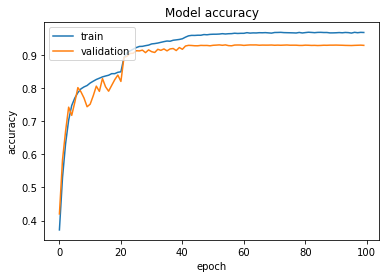

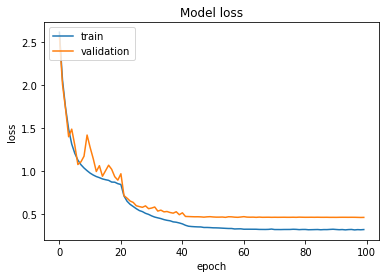

In [105]:
from matplotlib import pyplot as plt

#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()